## Set Up

In [1]:
import os
import sys
#set custom path
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\anaconda\envs\tf_keras_gpu_test\lib\site-packages'))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from torchvision import datasets, transforms
import torch

from copy import deepcopy as dc
import random
from statistics import mean


from PIL import Image
import requests
from io import BytesIO

from recommend_images import *

## 1. Import existing

In [3]:
#code to try clustering subset of embeddings

#import embeddings of existing dir
#all_embeds = np.load('../features.npy')
#np.save('../image_dir/features.npy', all_embeds[:1000])

In [10]:
#pull in base embeds
base_embeds  = np.load('../image_dir/features.npy')


#load base images
data_dir = '../image_dir/samples'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

image_datasets = datasets.ImageFolder(data_dir, transform = tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)
print(len(image_datasets)) #number of datapoints

10892


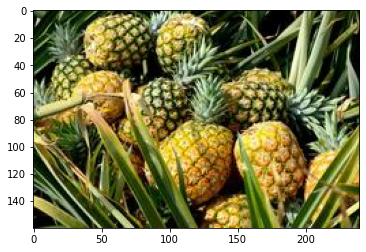

In [71]:
#test
file_keys = get_file_key('../image_dir/samples/pics')

plt.imshow((image_datasets[get_image(str(10889), file_keys)][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

## 1.5 Visualize Clusters

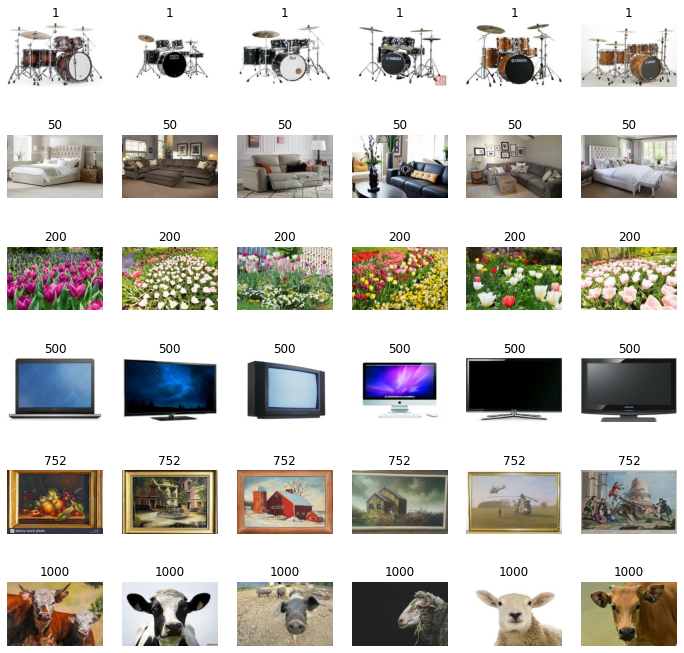

In [13]:
nrows =6
ncols = 6
cluster_choice = [1, 50, 200, 500, 752, 1000]

plt.figure(figsize=(12, 12))
position = 1
for i in range(nrows):
    cluster = cluster_choice[i]
    
    raw_ims = os.listdir(os.path.join('..\image_dir\clusters', str(cluster)))
    
    plot_indices = []
    for image in raw_ims:
        plot_indices.append(image.replace('.jpeg', ''))

    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow((image_datasets[get_image(plot_indices[j], file_keys)][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
        plt.title(cluster)      
    
        plt.axis("off")
        position += 1

plt.savefig('distribution_eval.jpeg')

## 2. Embed new image

In [7]:
%run distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\test_dir

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


In [14]:
#load test image embed
input_embed = np.load('../test_dir/features.npy')
print(input_embed.shape)

(1, 2048)


## 4. Recommend

In [34]:
def get_distance(input_embed, comparison_embeds):
    import scipy.spatial

    #translate to same size array as comparison
    input_expanded = np.repeat(input_embed, len(comparison_embeds), axis = 0)
    
    cluster_dist = scipy.spatial.distance.cdist(input_expanded, comparison_embeds, 'sqeuclidean')
    cluster_dist = cluster_dist[0] #only take one since all are duplicate
    return cluster_dist

def return_recommendation(input_embed, dir_path, plot_similar = False):
    
    cluster_centers = np.load(os.path.join(dir_path, 'centers.npy'))
    
    #find closest cluster center (add one to offset 0 start index)
    cluster_dist = get_distance(input_embed, cluster_centers)
    closest_cluster = cluster_dist.argsort()[0] + 1
    print(closest_cluster)

    #list images from within cluster
    similar_imgs = os.listdir(os.path.join(dir_path, 'clusters', str(closest_cluster)))
    
    #turn into int
    similar_idx = []
    for image in similar_imgs:
        temp_idx = int(str(image).replace('.jpeg', ''))
        similar_idx.append(temp_idx)
    
    #if plot is true plot similar images
    if bool(plot_similar):
        fig, axes = plt.subplots(1, 4, figsize = (10, 2))
        
        for i, ax in enumerate(axes.flat):
            ax.imshow((image_datasets[get_image(str(similar_idx[i]), file_keys)][0].detach().numpy().transpose(1, 2, 0)* 255).astype(np.uint8))
    return similar_imgs, closest_cluster

57


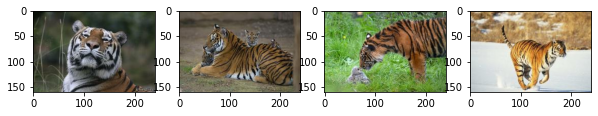

In [16]:
similar_imgs, closest_cluster = return_recommendation(input_embed, '../image_dir', plot_similar = True)

## 3. Find Duplicate

In [17]:
def photo_exists(input_embed, similar_imgs, dir_path):
    
    embed_dir = np.load(os.path.join(dir_path, 'features.npy'))
    
    #list images from within cluster
    similar_idx = []
    similar_embeds = []
    for image in similar_imgs:
        temp_idx = str(image).replace('.jpeg', '')

        image_idx = get_image(temp_idx, file_keys)
        #append based on image idx
        
        similar_idx.append(int(temp_idx))
        similar_embeds.append(embed_dir[image_idx])
    
    similar_distances = get_distance(input_embed, np.asarray(similar_embeds))
    
    if min(similar_distances) == 0:
        dup_idx = np.where(similar_distances == 0)[0][0]
   
        #drop duplicate image id
        similar_idx = np.delete(similar_idx, dup_idx)
   
        print("Photo exists")
    else:
        dup_idx = None
        print("Photo does not exist")
        
    return dup_idx

In [18]:
photo_exists(input_embed, similar_imgs, '../image_dir')

Photo exists


0

### Test on original image

In [13]:
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\Lighthouse_Labs\Final\distribution_clustering'))


%run distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\test2_dir

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


770


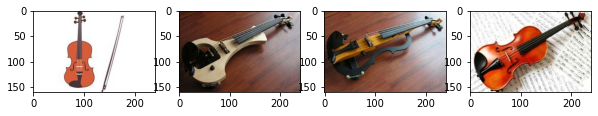

In [55]:
unique_embed = np.load('../test2_dir/features.npy')

similar_unique_imgs, unique_closest_cluster = return_recommendation(unique_embed, '../image_dir', plot_similar = True)

In [20]:
photo_exists(unique_embed, similar_imgs, '../image_dir')

Photo does not exist


## 4. Add input image to directory [UNDER CONSTRUCTION]

In [56]:
# [UNDER CONSTRUCTION]
def image_to_dir(input_embed, similar_imgs, input_path, dir_path, closest_cluster = None):
    import shutil
    #get index of duplicate within cluster
    dup_idx = photo_exists(input_embed, similar_imgs, dir_path)
    
    #if it is duplicate return input and existing duplicate
    if dup_idx is not None:
        
        #get name of image (aka the translated index)
        translated_dup_idx = similar_imgs[dup_idx].split('.')[0]
        
        #use get_image to visualize
        fig, axes = plt.subplots(1, 2)
        #plot input
        input_name = os.listdir(os.path.join(input_path, 'samples'))[0]
        im = Image.open(os.path.join(input_path, 'samples', input_name))
        
        axes[0].imshow(im)
        axes[0].title.set_text('Input')
        axes[1].imshow((image_datasets[get_image(translated_dup_idx, file_keys)][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
        axes[1].title.set_text('Existing Photo')
    
    #if not add it to the directory
    else:
        #Load embed, append new embed then save
        pre_embeds = np.load(os.path.join(dir_path, 'features.npy'))
        post_embeds = np.append(pre_embeds, input_embed, axis = 0)
        np.save(os.path.join(dir_path, 'features.npy'), post_embeds)
        #check this is the correct index to retrieve the embed
        #print(input_embed == post_embeds[len(pre_embeds)])
        
        #Copy image into its cluster - rename to match embed index
        input_image_path = os.path.join(input_path, 'samples', os.listdir(os.path.join(input_path, 'samples'))[0])
        #shutil.copyfile(input_image_path, os.path.join(dir_path, 'clusters', str(unique_closest_cluster), f"{str(len(pre_embeds))}.jpeg"))
        #shutil.copyfile(input_image_path, os.path.join(dir_path, 'samples/pics', f"{str(len(pre_embeds))}.jpeg"))
        
        

Photo exists


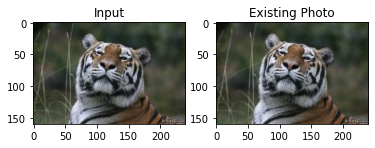

In [22]:
#with duplicate
image_to_dir(input_embed, similar_imgs, '../test_dir', '../image_dir')

In [26]:
#with non-duplicate
image_to_dir(unique_embed, similar_imgs, '../test2_dir', '../image_dir', unique_closest_cluster)

Photo does not exist


In [62]:
print(file_keys[-1:]) #this is the issue, with the indexing v. file name...

      file_name
idx            
10891      9999


In [68]:
file_keys.loc[file_keys['file_name'] == '10891']

file_name
idx          
993     10891

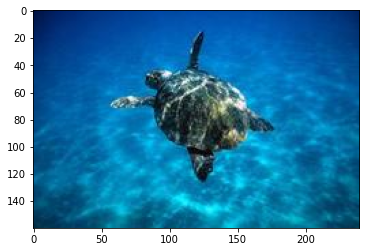

In [88]:
plt.imshow((image_datasets[993][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

17


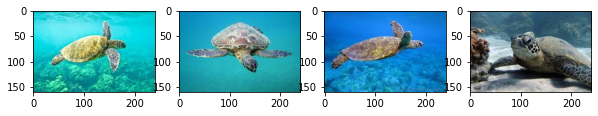

In [90]:
#Confirming that base embed index corresponds to file key index
test_embed = base_embeds[993].reshape(1, len(base_embeds[0]))

_, _ = return_recommendation(test_embed, '../image_dir', plot_similar = True)

## Test again

In [30]:
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\Lighthouse_Labs\Final\distribution_clustering'))


%run distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\input_test_dir

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


770


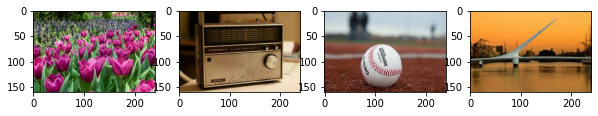

In [50]:
unique_embed = np.load('../test2_dir/features.npy')
#test
file_keys = get_file_key('../image_dir/samples/pics')

similar_unique_imgs, unique_closest_cluster = return_recommendation(unique_embed, '../image_dir', plot_similar = True)

In [19]:
stop

NameError: name 'stop' is not defined

## [Sample Testing]

In [ ]:
#cluster 
#%run ..\distribution_clustering\cluster_dataset.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\sample_dir

In [ ]:
#pull in test embeds
test_embeds  = np.load('../sample_dir/features.npy')
test_centers = np.load('../sample_dir/centers.npy')

#load test images
test_dir = '../sample_dir/samples'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

test_dataset = datasets.ImageFolder(test_dir, transform = tc)
dloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_dataset)) #number of datapoints

In [ ]:
input_expanded = np.repeat(input_embed, len(test_centers), axis = 0)
input_expanded.shape

In [ ]:
#get distances between input image and every test image
import scipy.spatial

center_dist = scipy.spatial.distance.cdist(input_expanded, test_centers, 'sqeuclidean')
#add one because cluster names start at 1
input_cluster = center_dist[0].argsort()[0] + 1
print(input_cluster)

In [ ]:
#load file keys for sample directory
temp_file_keys = get_file_key('../sample_dir/samples/pics')
get_image('5', temp_file_keys)

In [ ]:
return_recommendation('../test_dir', '../sample_dir', plot_similar = True)